In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections
import random
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation, Rescaling
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.initializers import HeNormal

In [2]:
classes = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]


checkpoints_path = 'best_model.h5'

In [3]:
def load_data(data_file):
    print('Loading data ...')
    with open(data_file, 'rb') as f:
        pickle_data = pickle.load(f)
        return pickle_data[0], pickle_data[1]

In [4]:
data_file = 'image_dataset.p'
images, labels = load_data(data_file)

n_samples = labels.shape[0]
print('Total samples:', n_samples)
print('images shape:', images.shape)
print('labels shape:', labels.shape)

Loading data ...
Total samples: 27766
images shape: (27766, 48, 48)
labels shape: (27766,)


# Explore the data

In [5]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

num_classes = len(emotions)

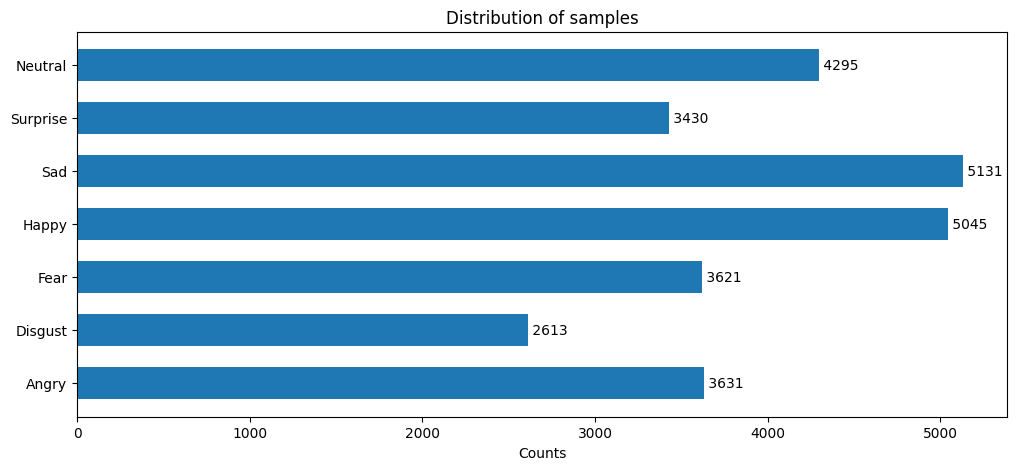

In [6]:
def plot_sample_distribution(labels):
    classes, cnts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 5))
    plt.barh(list(emotions.values()), cnts, height=0.6)
    for i, v in enumerate(cnts):
        plt.text(v, i, ' '+str(v), va='center')
    plt.xlabel('Counts')
    plt.title("Distribution of samples")

plot_sample_distribution(labels)

In [7]:
def show_images(images, labels, col=7):
    n = images.shape[0]
    row = int(np.ceil(n / col))
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(row, col, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(emotions[labels[i]])
        plt.xticks([]), plt.yticks([])
    plt.show()

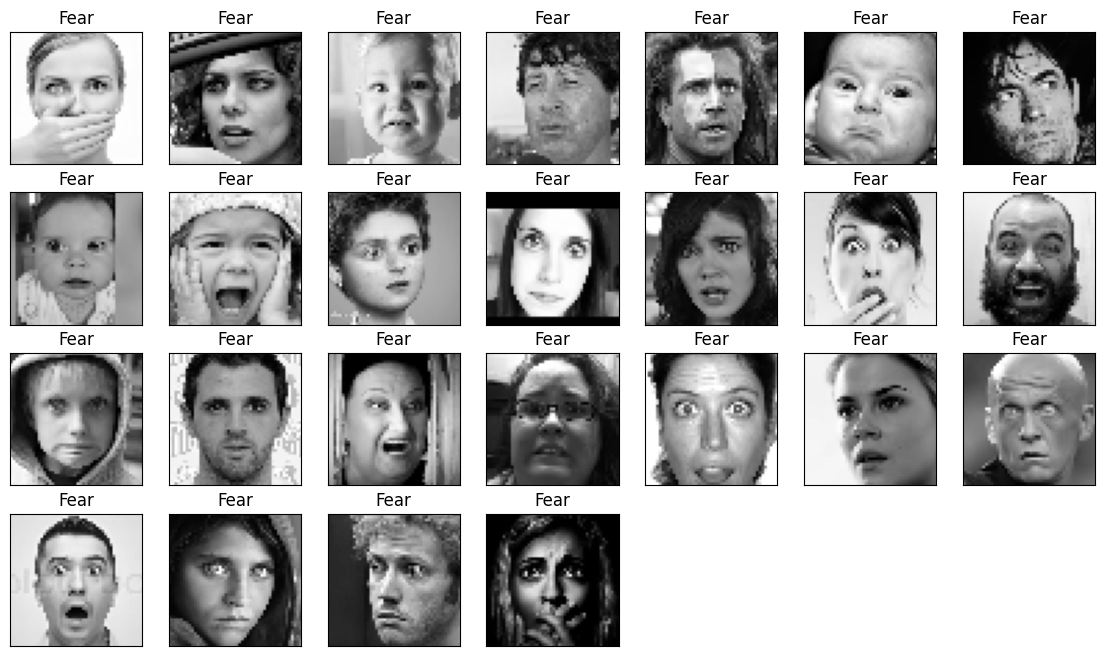

In [8]:
# Id is the emotion number, ex: 1 is Disgust

id = 2

def show_one_emotion(images, labels, id, start=0, num=25):
    image_x = images[labels==id]
    label_x = labels[labels==id]
    show_images(image_x[start:start+num], label_x[start:start+num])

show_one_emotion(images, labels, id=id)

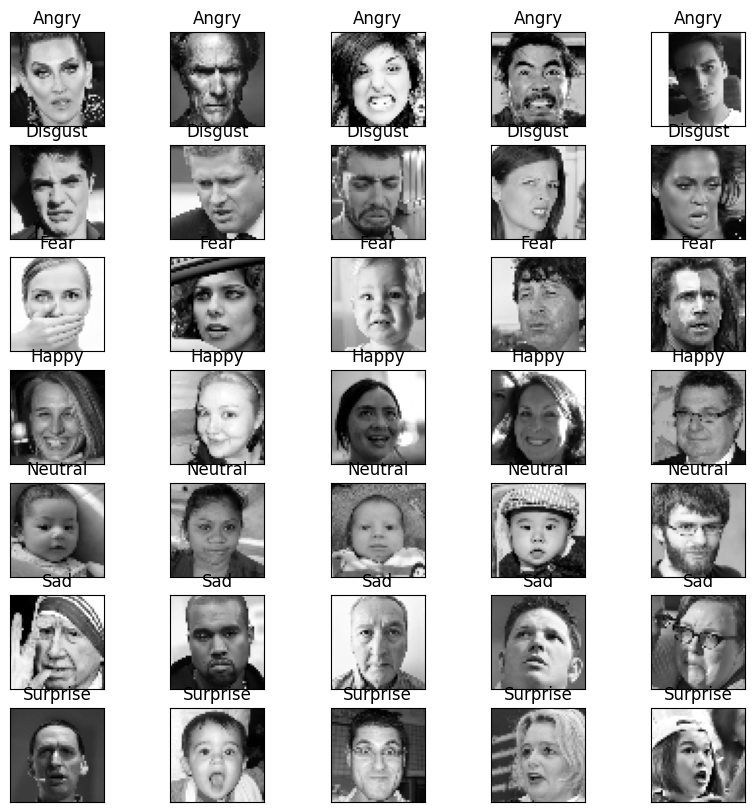

In [9]:


def show_images(images, labels, col=5):
    n = col * 7
    fig = plt.figure(figsize=(2*col, 10))
    for i, class_name in enumerate(classes):
        class_images = images[labels == i][:5]
        for j in range(col):
            fig.add_subplot(7, col, i*col+j+1)
            if j < len(class_images):
                plt.imshow(class_images[j], cmap='gray')
                plt.title(class_name)
            plt.xticks([]), plt.yticks([])
    plt.show()

show_images(images, labels)


# Split dataset

In [10]:
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])
print('Test samples:', label_test.shape[0])

Training samples: 17769
Validation samples: 4443
Test samples: 5554


# **Upsamling training data**

In [11]:
def upsampling(x, y, strategy):
    (n, w, h) = x.shape
    sm = SMOTE(sampling_strategy=strategy, random_state=42)
    x_flat = x.reshape((n,-1))
    x_up, y_up = sm.fit_resample(x_flat, y)
    n_up = x_up.shape[0]
    x_up = x_up.reshape((n_up,w,h))

    return x_up, y_up

In [12]:
collections.Counter(label_train)

Counter({0: 2349, 3: 3202, 4: 3311, 2: 2297, 5: 2179, 6: 2748, 1: 1683})

In [13]:
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

In [14]:
collections.Counter(label_train_up)

Counter({0: 3311, 3: 3311, 4: 3311, 2: 3311, 5: 3311, 6: 3311, 1: 3311})

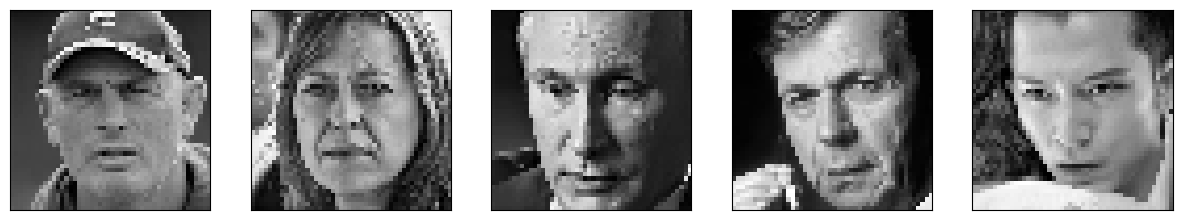

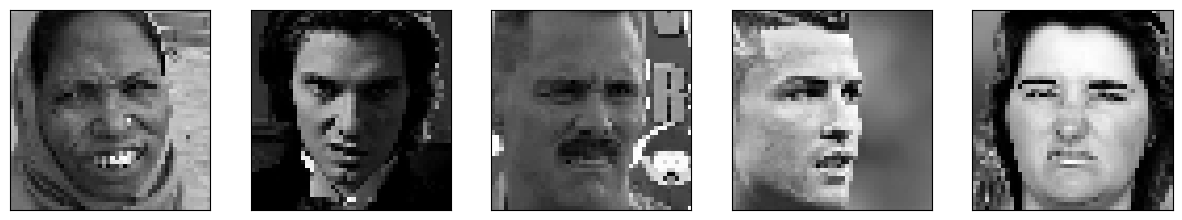

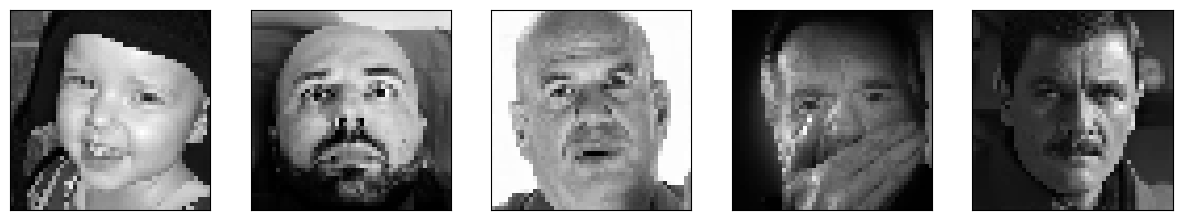

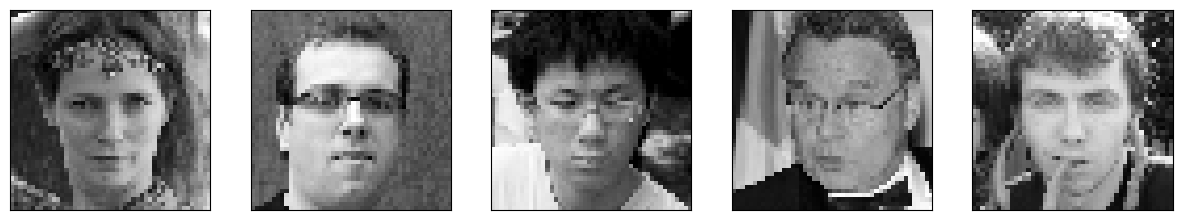

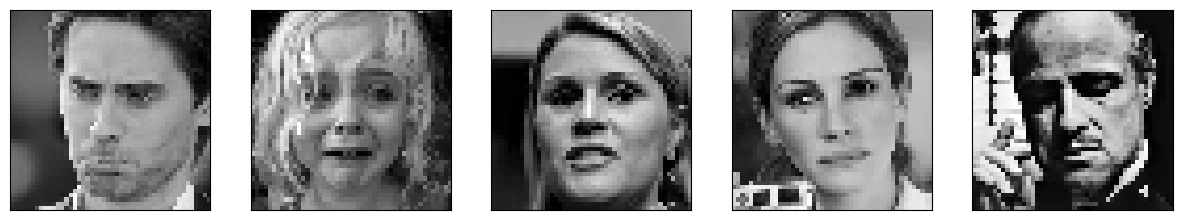

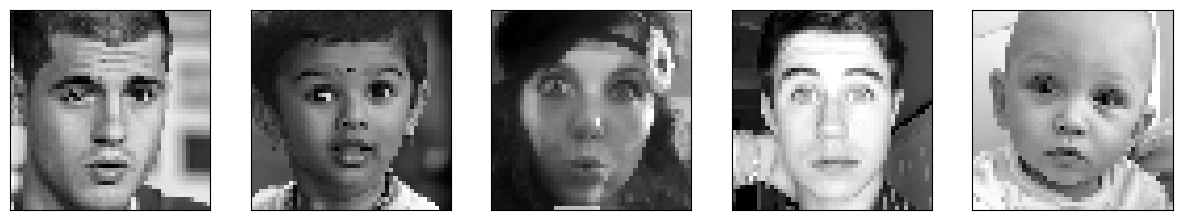

In [15]:
def show_one_emotion(images, labels, id, start=0, num=5):
    fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(15, 15))
    axes = axes.flatten()
    for i in range(start, start+num):
        img = images[labels == id][i]
        axes[i-start].imshow(img, cmap="gray")
        axes[i-start].set_xticks(())
        axes[i-start].set_yticks(())
    plt.show()

num_classes = len(np.unique(label_train_up))

for i in range(num_classes):
    if i == 3:
        continue
    show_one_emotion(image_train_up, label_train_up, id=i, start=0, num=5)


# Utils

In [16]:
def one_hot_encoding(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes)

In [17]:
def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize)
    return x

In [18]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y

In [19]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model '+name)
        plt.legend()
    plt.show()

In [20]:
def evaluate_class(model, x_test, y_test):
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    for i in range(num_classes):
        x = x_test[labels==i]
        y = y_test[labels==i]
        loss, acc = model.evaluate(x,  y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[i], acc))
    print('-'*23)
    loss, acc = model.evaluate(x_test,  y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))

# Model

In [21]:
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)
x_test, y_test = pre_processing(image_test, label_test, num_classes)

train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

In [22]:
epochs = 200

cp = ModelCheckpoint(filepath = checkpoints_path, save_weights_only=False, monitor='val_accuracy',  mode='max', save_best_only=True,  verbose=1)

#Early Stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

#Learning rate reduction
lr = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [23]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
        
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0

In [24]:
history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[lr, es, cp])

Epoch 1/200
181/181 [==============================] - ETA: 0s - loss: 2.0841 - accuracy: 0.1775
Epoch 1: val_accuracy improved from -inf to 0.18073, saving model to best_model.h5
181/181 [==============================] - 28s 81ms/step - loss: 2.0841 - accuracy: 0.1775 - val_loss: 2.1793 - val_accuracy: 0.1807 - lr: 0.0010
Epoch 2/200
181/181 [==============================] - ETA: 0s - loss: 1.8341 - accuracy: 0.2192
Epoch 2: val_accuracy improved from 0.18073 to 0.19176, saving model to best_model.h5
181/181 [==============================] - 13s 72ms/step - loss: 1.8341 - accuracy: 0.2192 - val_loss: 2.1100 - val_accuracy: 0.1918 - lr: 0.0010
Epoch 3/200
180/181 [============================>.] - ETA: 0s - loss: 1.7552 - accuracy: 0.2479
Epoch 3: val_accuracy improved from 0.19176 to 0.27977, saving model to best_model.h5
181/181 [==============================] - 13s 72ms/step - loss: 1.7552 - accuracy: 0.2479 - val_loss: 1.7743 - val_accuracy: 0.2798 - lr: 0.0010
Epoch 4/200
181/

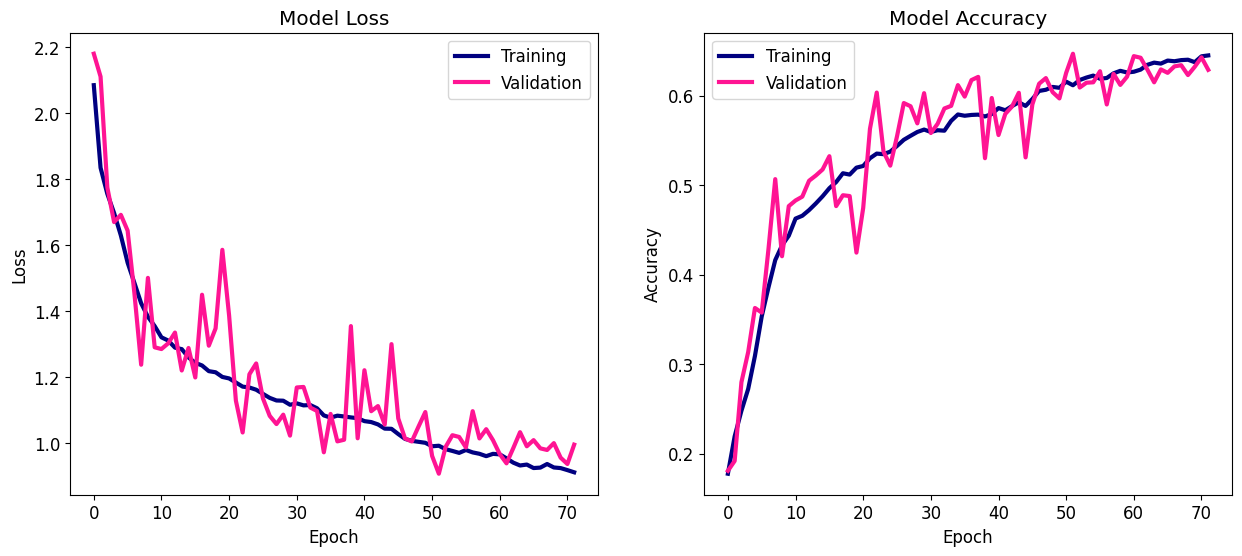

In [25]:
plot_metrics(history)

In [26]:
save_model = model.save("model_AffectNet7_48.h5")

In [28]:
# model.load_weights(model.checkpoint_path)
model = load_model("best_model.h5")
evaluate_class(model, x_test, y_test)

Emotion        Accuracy
-----------------------
Angry          52.0%
Disgust        65.3%
Fear           53.1%
Happy          87.5%
Sad            83.7%
Surprise       57.4%
Neutral        40.3%
-----------------------
Overall        64.6%


# Confussion Matrix

In [29]:
from sklearn.metrics import confusion_matrix

# Make predictions on test data
y_pred = model.predict(image_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(label_test, y_pred)
print(cm)


174/174 [==============================] - 1s 7ms/step
[[373 188  40   4   8  90  14]
 [ 64 345  34   6   5  58  16]
 [ 71  67 393   4   1 105  99]
 [  1  18   1 903  98   5   6]
 [ 29  10   7  50 836  30  37]
 [116  97  48   0  11 403  27]
 [ 36  45 259  16  40 103 337]]


              precision    recall  f1-score   support

       Angry       0.54      0.52      0.53       717
     Disgust       0.45      0.65      0.53       528
        Fear       0.50      0.53      0.52       740
       Happy       0.92      0.88      0.90      1032
     Neutral       0.84      0.84      0.84       999
         Sad       0.51      0.57      0.54       702
    Surprise       0.63      0.40      0.49       836

    accuracy                           0.65      5554
   macro avg       0.63      0.63      0.62      5554
weighted avg       0.66      0.65      0.65      5554



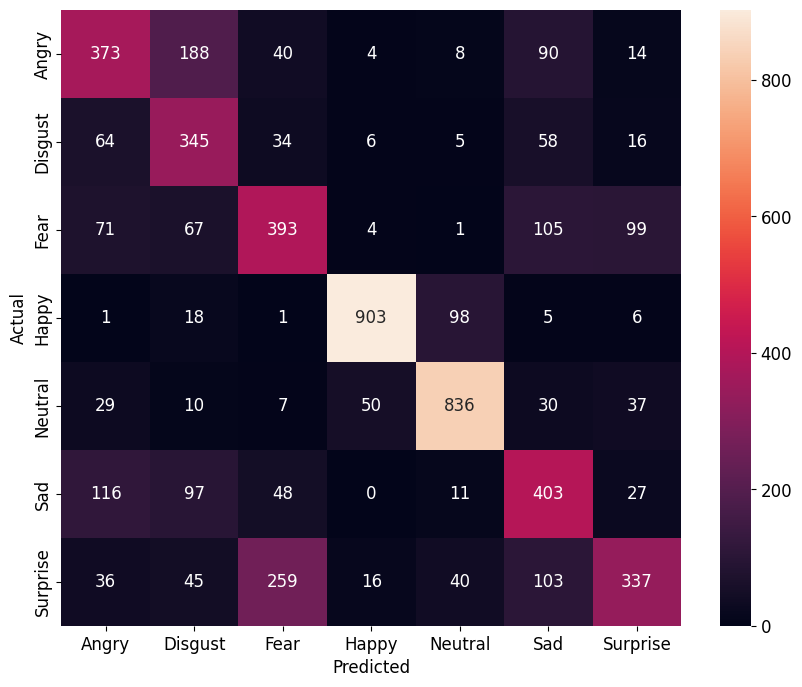

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
confusion_mtx = confusion_matrix(label_test, y_pred)

# Print the classification report
class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]  # replace with your own class names
print(classification_report(label_test, y_pred, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
confusion_mtx = confusion_matrix(label_test, y_pred)

# Calculate overall accuracy
overall_accuracy = (confusion_mtx.diagonal().sum() / confusion_mtx.sum()) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

# Calculate class accuracy
class_accuracy = {}
for i in range(len(class_names)):
    class_accuracy[class_names[i]] = (confusion_mtx[i,i] / confusion_mtx[i,:].sum()) * 100
    print(f"{class_names[i]} Accuracy: {class_accuracy[class_names[i]]:.2f}%")

Overall Accuracy: 64.64%
Angry Accuracy: 52.02%
Disgust Accuracy: 65.34%
Fear Accuracy: 53.11%
Happy Accuracy: 87.50%
Neutral Accuracy: 83.68%
Sad Accuracy: 57.41%
Surprise Accuracy: 40.31%


# Unseen Batch

In [32]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [33]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


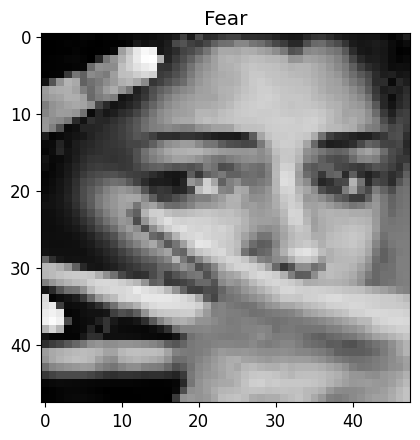

In [34]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = classes[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


4/4 [==============================] - 0s 21ms/step
Accuracy: 39.2578125
Angry 293/2100 acc: 57.3
Disgust 291/2100 acc: 66.7
Fear 294/2100 acc: 59.9
Happy 289/2100 acc: 4.2
Neutral 296/2100 acc: 1.0
Sad 290/2100 acc: 63.8
Surprise 295/2100 acc: 22.4


In [36]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 39.2578125
Angry 293/2100 acc: 57.3
Disgust 291/2100 acc: 66.7
Fear 294/2100 acc: 59.9
Happy 289/2100 acc: 4.2
Neutral 296/2100 acc: 1.0
Sad 290/2100 acc: 63.8
Surprise 295/2100 acc: 22.4


              precision    recall  f1-score   support

       Angry       0.44      0.57      0.49       293
     Disgust       0.39      0.67      0.49       291
        Fear       0.44      0.60      0.51       294
       Happy       0.75      0.04      0.08       289
     Neutral       0.11      0.01      0.02       296
         Sad       0.34      0.64      0.44       290
    Surprise       0.40      0.22      0.29       295

    accuracy                           0.39      2048
   macro avg       0.41      0.39      0.33      2048
weighted avg       0.41      0.39      0.33      2048



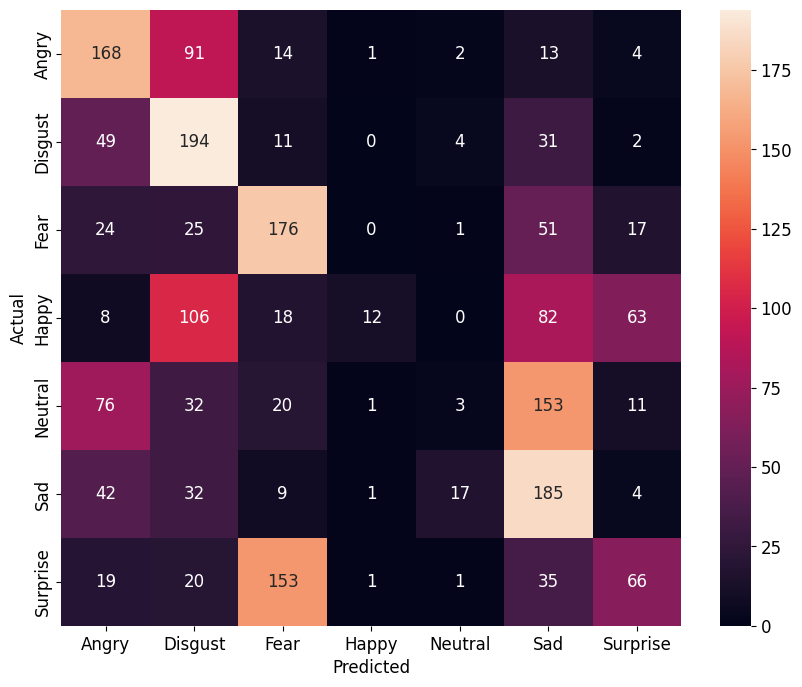

In [37]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with images

In [58]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the colors for each emotion
emotions = {
    0: ['Angry', (0,0,255)],
    1: ['Disgust', (0,102,0)],
    2: ['Fear', (255,255,153)],
    3: ['Happy', (153,0,153)],
    4: ['Sad', (255,0,0)],
    5: ['Surprise', (0,255,0)],
    6: ['Neutral', (160,160,160)]
}

# Load the image
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI from the original image
    face_image = image[y:y+h, x:x+w]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to grayscale
    normalized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    normalized_image = normalized_image.astype('float32')

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Get the color for the predicted emotion
    color = emotions[predicted_class_index][1]

    # Draw a rectangle around the detected face with the corresponding color
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Resize the image to 1800x1200 pixels
image = cv2.resize(image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 23ms/step
Predicted emotion class: sad, probability: 0.7985390424728394
1/1 [==============================] - 0s 27ms/step
Predicted emotion class: surprise, probability: 0.9998112320899963
1/1 [==============================] - 0s 31ms/step
Predicted emotion class: fear, probability: 0.7220748662948608
1/1 [==============================] - 0s 22ms/step
Predicted emotion class: sad, probability: 0.6166070103645325
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: happy, probability: 0.9918322563171387
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: angry, probability: 0.9947086572647095
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: angry, probability: 0.9716494083404541
1/1 [==============================] - 0s 23ms/step
Predicted emotion class: sad, probability: 0.9391486048698425
1/1 [==============================] - 0s 21ms/step
Predicted emotion class:

# Video

In [61]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the colors for each emotion
emotions = {
    0: ['Angry', (0,0,255)],
    1: ['Disgust', (0,102,0)],
    2: ['Fear', (255,255,153)],
    3: ['Happy', (153,0,153)],
    4: ['Sad', (255,0,0)],
    5: ['Surprise', (0,255,0)],
    6: ['Neutral', (160,160,160)]
}

# Create a VideoCapture object to capture frames from the webcam
video_capture = cv2.VideoCapture(0)

while True:
    # Capture a frame from the webcam
    ret, frame = video_capture.read()

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

    # Loop through each detected face
    for (x, y, w, h) in faces:
        # Extract the face ROI from the original frame
        face_image = frame[y:y+h, x:x+w]

        # Resize the face ROI to 48x48 pixels
        resized_image = cv2.resize(face_image, (48, 48))

        # Convert the resized image to grayscale
        normalized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        normalized_image = normalized_image.astype('float32')

        # Make a prediction on the normalized image using the loaded model
        predictions = model.predict(np.expand_dims(normalized_image, axis=0))

        # Get the index of the highest predicted class
        predicted_class_index = np.argmax(predictions)

        # Print the predicted emotion class and its corresponding probability
        predicted_class = emotion_classes[predicted_class_index]
        predicted_probability = predictions[0][predicted_class_index]
        print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

        # Get the color for the predicted emotion
        color = emotions[predicted_class_index][1]

        # Draw a rectangle around the detected face with the corresponding color
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

        # Display the predicted emotion class and its corresponding probability on the frame
        text = f"{predicted_class} ({predicted_probability:.2f})"
        cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Display the frame with the detected faces and their predictions
    cv2.imshow("Webcam", frame)

    # Check if the user pressed the 'q' key to quit the program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
Predicted emotion class: fear, probability: 0.6552807688713074
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fear, probability: 0.7833343744277954
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: fear, probability: 0.9380834698677063
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: fear, probability: 0.9530553221702576
1/1 [==============================] - 0s 19ms/step
Predicted emotion class: fear, probability: 0.8754827976226807
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: fear, probability: 0.8754827976226807
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: fear, probability: 0.6696915030479431
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fear, probability: 0.8481820821762085
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fea